In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage.metrics import structural_similarity
from torch.nn import MSELoss
mse_loss = MSELoss(size_average = True)

from basicsr.models import create_model, load_finetuned_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.models.image_restoration_model import ImageRestorationModel
from basicsr.utils.options import parse

from tqdm.notebook import tqdm as log_progress
from collections import OrderedDict

/home/gridsan/tye/.conda/envs/test/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Loading in our finetuned weights to the NAFNet model
finetuned_weight_path = 'finetuned_weights.pth'
config_path = 'model_config.yml'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finetuned = load_finetuned_model(finetuned_weight_path, config_path)

2025-02-21 19:51:43,206 INFO: Model [ImageRestorationModel] is created.


Finetuned weights loaded successfully!


In [4]:
# Loading different samples from the MPM Dataset
samp_name = ["twop_G", "conf_M"]

samples = np.load('FMD_samples.npz', allow_pickle = True)

gt_dict = samples["gt_dict"].item()
noisy_dict = samples["noisy_dict"].item()

In [5]:
#Predetermined Lhat values to ensure statistical coverage on the intervals
lhat = [2.1643288, 2.204409,  2.3647294, 2.284569, 2.3647294, 1.6232464, 2.204409, 2.224449, 2.1843688, 2.1643288, 2.1242485, 2.0440881, 2.024048, 1.9839679, 1.9639279, 1.8036072, 1.763527, 1.7234468,1.7034068,1.4428858  ]

In [6]:
test = []
test_ssim = []

denoised_dict = {}
uncertain_dict = {}
mse_dict = {}
ssim_dict = {}

for key, single_image in noisy_dict.items():
    single_gt = gt_dict[key]
    uncertainties, multi_predictions, mses, ssim_vals = [], [], [], []
    single_gt = [gt for gt in single_gt] 
    
    for i, in_img in enumerate(single_image):
        in_img = in_img.unsqueeze(0).to(device)  # (1, 5, 512, 512)

        out = finetuned(in_img.float())  # (1, 5, 3, 512, 512)

        # Extract prediction and uncertainty bounds
        upper = out[0, 2, :, :].detach().cpu()
        pred = out[0, 1, :, :].detach().cpu()
        lower = out[0, 0, :, :].detach().cpu()

        pred /= torch.max(pred)  # Normalize prediction
        multi_predictions.append(pred)

        # Compute uncertainty
        uncertainty = ((upper - lower) * lhat[i]).cpu().numpy()
        uncertainties.append(uncertainty)

        # Compute MSE and SSIM
        err = mse_loss(pred.float(), single_gt[i])
        mses.append(err)
        ssim_vals.append(structural_similarity(pred.numpy(), single_gt[i][0, :,:].numpy()))

    # Store results in dictionaries
    denoised_dict[key] = multi_predictions
    uncertain_dict[key] = uncertainties
    mse_dict[key] = mses
    ssim_dict[key] = ssim_vals

/home/gridsan/tye/.conda/envs/test/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([20, 512, 512])) that is different to the input size (torch.Size([512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/gridsan/tye/.conda/envs/test/lib/python3.7/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


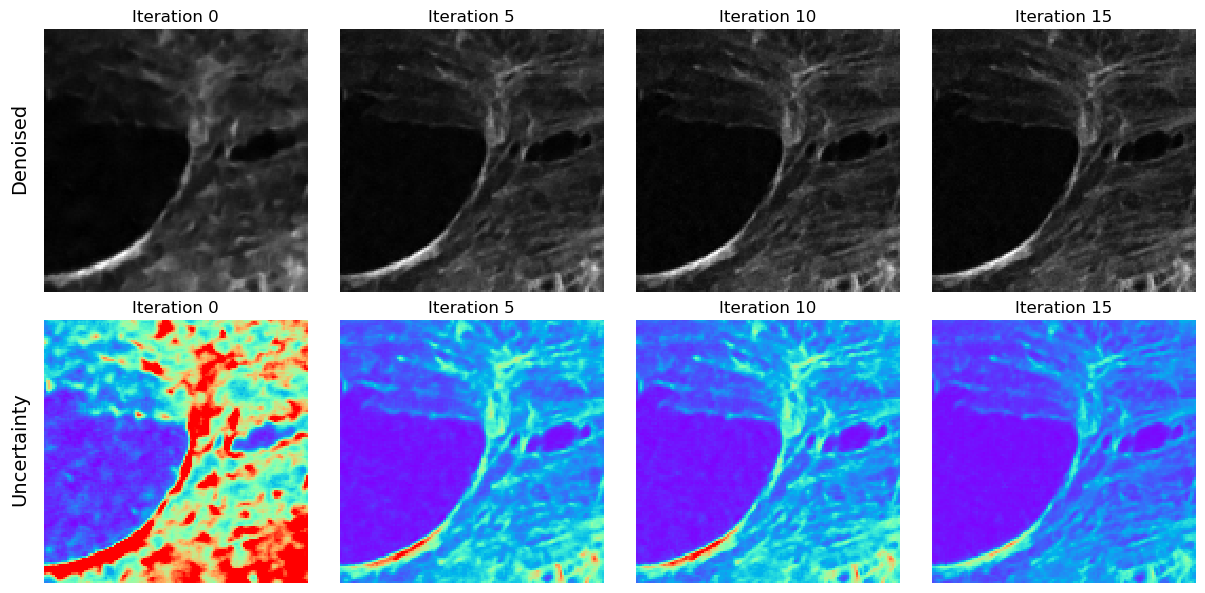

In [7]:
#Looking at Uncertainty Trends for an FMD Sample
sample = "twop_G"

denoised_sample = denoised_dict[sample]
uncertainty_sample = uncertain_dict[sample]

fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
x = 150
y = 130
for i in range(4):
    axes[0, i].imshow(denoised_sample[i * 5][x:x + 125, y: y + 125], cmap = "gray")  
    axes[0, i].axis("off") 
    axes[0, i].set_title(f"Iteration {i * 5}")

for i in range(4):
    axes[1, i].imshow(uncertainty_sample[i * 5][x:x + 125,y: y + 125], cmap="rainbow", vmax = np.max(uncertainty_sample[15]))  
    axes[1, i].axis("off")  
    axes[1, i].set_title(f"Iteration {i * 5}")


fig.text(0.0, 0.75, "Denoised", va="center", ha="center", fontsize=14, rotation=90)
fig.text(0.0, 0.25, "Uncertainty", va="center", ha="center", fontsize=14, rotation=90)
plt.tight_layout()
plt.show()

In [8]:
tot_pix_scanned = 512 * 512 * 20

# ADAPTIVE PART
gt_name = "conf_M"
noisy_ims_torch = noisy_dict[gt_name][-1]

x, y = 80, 300
percents = list(range(90, 100, 1))

adaptive_dict = {}
uncertainty_dict = {}
mse_error_list = []

with torch.no_grad():
    for percent in log_progress(percents):
        adaptive_images = []
        uncertainty_perc = []
        num_pixels_scanned = []

        # Prepare input image batch
        noisy_0 = noisy_ims_torch[0]
        in_img = noisy_0.repeat(20, 1, 1).unsqueeze(0).to(device)

        # Initial model inference
        out = finetuned(in_img.float())[0].detach().cpu()
        uncertainty_0 = torch.clamp((out[2] - out[0]) * lhat[-1], 0, 1)

        num_pixels_scanned.append(in_img.shape[-1] ** 2)
        unc_thresh = np.percentile(uncertainty_0, percent)
        
        for i in range(1, 20):
            mask = uncertainty_0 >= unc_thresh
            noisy_now = torch.where(mask, noisy_ims_torch[i], noisy_0)
            num_pixels_scanned.append(mask.sum().item())

            in_img[0, i] = noisy_now.to(device)

            out = finetuned(in_img.float())[0].detach().cpu()
            adaptive_images.append(out[1].clone())

            uncertainty_0 = (out[2] - out[0]) * lhat[-1]
            uncertainty_perc.append(uncertainty_0.clone())

        perc_pix_rescanned = sum(num_pixels_scanned) / tot_pix_scanned
        adaptive_dict[percent] = adaptive_images
        uncertainty_dict[percent] = uncertainty_perc

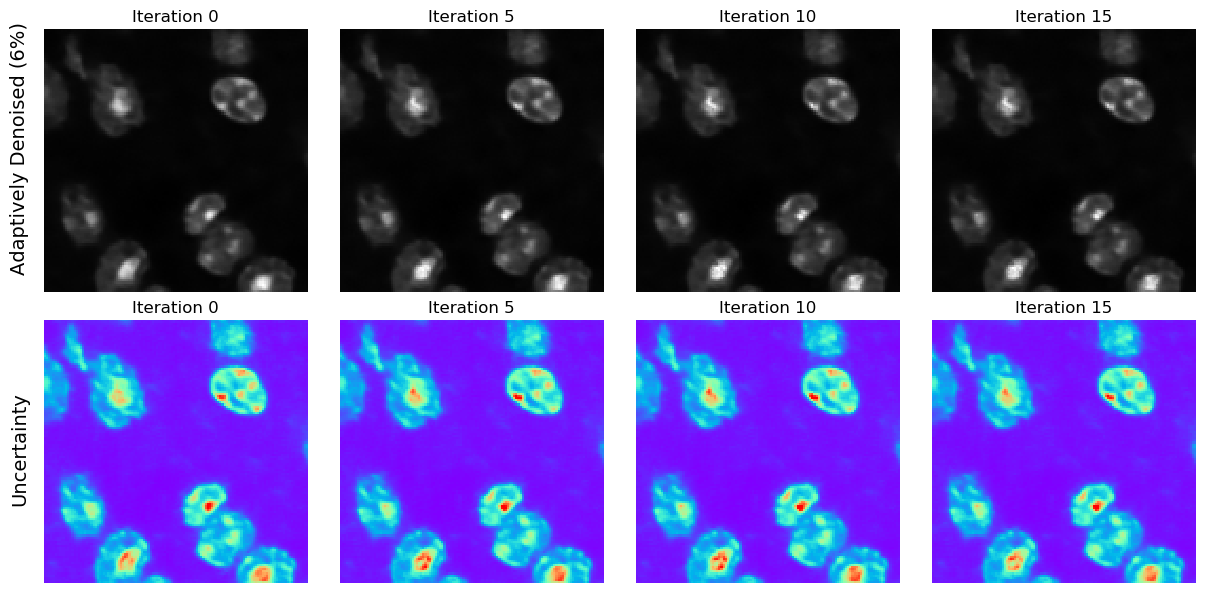

In [9]:
adaptive_perc = adaptive_dict[99]
uncertainty_perc = uncertainty_dict[99]

fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
x = 0
y = 250
for i in range(4):
    axes[0, i].imshow(adaptive_perc[i * 5][x:x + 125, y: y + 125], cmap = "gray")  
    axes[0, i].axis("off") 
    axes[0, i].set_title(f"Iteration {i * 5}")

for i in range(4):
    axes[1, i].imshow(uncertainty_perc[i * 5][x:x + 125,y: y + 125], cmap="rainbow", vmax = torch.max(uncertainty_perc[0]))  
    axes[1, i].axis("off")  
    axes[1, i].set_title(f"Iteration {i * 5}")

fig.text(0.0, 0.75, "Adaptively Denoised (6%)", va="center", ha="center", fontsize=14, rotation=90)
fig.text(0.0, 0.25, "Uncertainty", va="center", ha="center", fontsize=14, rotation=90)
plt.tight_layout()
plt.show()